In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [2]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from pprint import pprint
from math import ceil
from time import time

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
print("TF version : ", tf.__version__)
print("Keras version : ", keras.__version__)
with_cuda = tf.test.is_built_with_cuda()
with_gpu = tf.test.is_gpu_available()
print("Built with CUDA : ", with_cuda)
print("Available GPU : ", with_gpu)

if with_cuda and with_gpu:
    keras.backend.set_image_data_format('channels_first')
else: 
    keras.backend.set_image_data_format('channels_last')

print("keras data_format : ", keras.backend.image_data_format())

TF version :  1.10.0
Keras version :  2.1.6-tf
Built with CUDA :  True
Available GPU :  True
keras data_format :  channels_first


In [4]:
BATCH_SIZE = 128
EPOCHS = 200
INIT_LR = 0.1

In [5]:
print("... loading CIFAR10 dataset ...")
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
y_train = np.squeeze(y_train)
y_test = np.squeeze(y_test)

x_train, y_train = shuffle(x_train, y_train, random_state=51)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train,
                                                  test_size=0.2,
                                                  stratify=y_train,
                                                  random_state=51)
# cast samples and labels
x_train = x_train.astype(np.float32)
x_val = x_val.astype(np.float32)
x_test = x_test.astype(np.float32)
y_train = keras.utils.to_categorical(y_train.astype(np.int32), num_classes=10)
y_val = keras.utils.to_categorical(y_val.astype(np.int32), num_classes=10)
y_test = keras.utils.to_categorical(y_test.astype(np.int32), num_classes=10)

print("\tTRAIN - images {} | {}  - labels {} - {}".format(x_train.shape, x_train.dtype, y_train.shape, y_train.dtype))
print("\tVAL - images {} | {}  - labels {} - {}".format(x_val.shape, x_val.dtype, y_val.shape, y_val.dtype))
print("\tTEST - images {} | {}  - labels {} - {}\n".format(x_test.shape, x_test.dtype, y_test.shape, y_test.dtype))

... loading CIFAR10 dataset ...
	TRAIN - images (40000, 3, 32, 32) | float32  - labels (40000, 10) - float32
	VAL - images (10000, 3, 32, 32) | float32  - labels (10000, 10) - float32
	TEST - images (10000, 3, 32, 32) | float32  - labels (10000, 10) - float32



In [6]:
generator_aug = keras.preprocessing.image.ImageDataGenerator(samplewise_center=True,
                                                             samplewise_std_normalization=True,
                                                             width_shift_range=5,
                                                             height_shift_range=5,
                                                             fill_mode='constant',
                                                             cval=0.0,
                                                             horizontal_flip=True,
                                                             vertical_flip=False,
                                                             data_format=keras.backend.image_data_format())

generator = keras.preprocessing.image.ImageDataGenerator(samplewise_center=True,
                                                         samplewise_std_normalization=True,
                                                         data_format=keras.backend.image_data_format())

# python iterator object that yields augmented samples 
iterator_train_aug = generator_aug.flow(x_train, y_train, batch_size=BATCH_SIZE)

# python iterators object that yields not augmented samples 
iterator_train = generator.flow(x_train, y_train, batch_size=BATCH_SIZE)
iterator_valid = generator.flow(x_val, y_val, batch_size=BATCH_SIZE)
iterator_test = generator.flow(x_test, y_test, batch_size=BATCH_SIZE)

steps_per_epoch_train = int(ceil(iterator_train.n/BATCH_SIZE))
steps_per_epoch_val = int(ceil(iterator_valid.n/BATCH_SIZE))
steps_per_epoch_test = int(ceil(iterator_test.n/BATCH_SIZE))

In [7]:
# test iterator with data augmentation
x, y = iterator_train_aug.next()

print("x : {} | {}".format(x.shape, x.dtype))
print("y : {} | {}".format(y.shape, y.dtype))

x : (128, 3, 32, 32) | float32
y : (128, 10) | float32


# Build Keras model

In [8]:
from resnet import ResNet56

In [9]:
shape = [3, 32, 32] if keras.backend.image_data_format()=='channels_first' else [32, 32, 3]

model = ResNet56(input_shape=shape, classes=10, p=0.95, activation='drop-activation').build_model()

Instructions for updating:
`normal` is a deprecated alias for `truncated_normal`


In [10]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 3, 32, 32)    0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 16, 30, 30)   432         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 16, 30, 30)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
drop_activation_keras (DropActi (None, 16, 30, 30)   0           batch_normalization[0][0]        
__________________________________________________________________________________________________
conv2d_2 (

In [11]:
optimizer = keras.optimizers.SGD(lr=INIT_LR, momentum=0.9)
loss = 'categorical_crossentropy'
metrics = ['acc', ]
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [12]:
# model.save_weights('random_weights.h5')
model.load_weights('random_weights.h5')

# Train model

In [13]:
callbacks = []

model_ckpt = keras.callbacks.ModelCheckpoint("model_ckpt_dropactivation_best_drop-activation.h5",
                                             monitor='val_acc', verbose=1, save_best_only=True, 
                                             save_weights_only=True)
callbacks.append(model_ckpt)

def schedule(epoch):
    if epoch < 91:
        return INIT_LR
    if epoch < 136:
        return 0.1*INIT_LR
    if epoch < 182:
        return 0.01*INIT_LR
    else:
        return 0.001*INIT_LR
    
lr_schedule = keras.callbacks.LearningRateScheduler(schedule, verbose=1)
callbacks.append(lr_schedule)

In [14]:
%%time

history = model.fit_generator(iterator_train_aug, 
                              steps_per_epoch=steps_per_epoch_train,
                              epochs=EPOCHS,
                              verbose=1,
                              validation_data=iterator_valid,
                              validation_steps=steps_per_epoch_val,
                              callbacks=callbacks)


Epoch 00001: LearningRateScheduler reducing learning rate to 0.1.
Epoch 1/200
312/313 [============================>.] - ETA: 0s - loss: 2.3975 - acc: 0.4005
Epoch 00001: val_acc improved from -inf to 0.20950, saving model to model_ckpt_dropactivation_best_drop-activation.h5
313/313 [==============================] - 58s 186ms/step - loss: 2.3962 - acc: 0.4010 - val_loss: 5.5294 - val_acc: 0.2095

Epoch 00002: LearningRateScheduler reducing learning rate to 0.1.
Epoch 2/200
312/313 [============================>.] - ETA: 0s - loss: 1.8522 - acc: 0.5649
Epoch 00002: val_acc improved from 0.20950 to 0.40030, saving model to model_ckpt_dropactivation_best_drop-activation.h5
313/313 [==============================] - 36s 114ms/step - loss: 1.8518 - acc: 0.5651 - val_loss: 2.7484 - val_acc: 0.4003

Epoch 00003: LearningRateScheduler reducing learning rate to 0.1.
Epoch 3/200
312/313 [============================>.] - ETA: 0s - loss: 1.5802 - acc: 0.6235
Epoch 00003: val_acc improved from 0

312/313 [============================>.] - ETA: 0s - loss: 0.7244 - acc: 0.8375
Epoch 00023: val_acc did not improve from 0.75700
313/313 [==============================] - 36s 114ms/step - loss: 0.7244 - acc: 0.8375 - val_loss: 1.2299 - val_acc: 0.7056

Epoch 00024: LearningRateScheduler reducing learning rate to 0.1.
Epoch 24/200
312/313 [============================>.] - ETA: 0s - loss: 0.7213 - acc: 0.8368
Epoch 00024: val_acc did not improve from 0.75700
313/313 [==============================] - 36s 114ms/step - loss: 0.7215 - acc: 0.8367 - val_loss: 1.0886 - val_acc: 0.7421

Epoch 00025: LearningRateScheduler reducing learning rate to 0.1.
Epoch 25/200
312/313 [============================>.] - ETA: 0s - loss: 0.7192 - acc: 0.8405
Epoch 00025: val_acc improved from 0.75700 to 0.76350, saving model to model_ckpt_dropactivation_best_drop-activation.h5
313/313 [==============================] - 36s 115ms/step - loss: 0.7186 - acc: 0.8408 - val_loss: 0.9987 - val_acc: 0.7635

Epoch 

312/313 [============================>.] - ETA: 0s - loss: 0.6752 - acc: 0.8606
Epoch 00047: val_acc did not improve from 0.82610
313/313 [==============================] - 36s 114ms/step - loss: 0.6751 - acc: 0.8606 - val_loss: 1.0994 - val_acc: 0.7529

Epoch 00048: LearningRateScheduler reducing learning rate to 0.1.
Epoch 48/200
312/313 [============================>.] - ETA: 0s - loss: 0.6814 - acc: 0.8613
Epoch 00048: val_acc did not improve from 0.82610
313/313 [==============================] - 36s 114ms/step - loss: 0.6811 - acc: 0.8614 - val_loss: 0.9977 - val_acc: 0.7837

Epoch 00049: LearningRateScheduler reducing learning rate to 0.1.
Epoch 49/200
312/313 [============================>.] - ETA: 0s - loss: 0.6735 - acc: 0.8664
Epoch 00049: val_acc did not improve from 0.82610
313/313 [==============================] - 36s 114ms/step - loss: 0.6736 - acc: 0.8662 - val_loss: 0.9649 - val_acc: 0.7623

Epoch 00050: LearningRateScheduler reducing learning rate to 0.1.
Epoch 50/20


Epoch 00072: LearningRateScheduler reducing learning rate to 0.1.
Epoch 72/200
312/313 [============================>.] - ETA: 0s - loss: 0.6580 - acc: 0.8727
Epoch 00072: val_acc did not improve from 0.82610
313/313 [==============================] - 36s 113ms/step - loss: 0.6582 - acc: 0.8726 - val_loss: 1.1229 - val_acc: 0.7520

Epoch 00073: LearningRateScheduler reducing learning rate to 0.1.
Epoch 73/200
312/313 [============================>.] - ETA: 0s - loss: 0.6511 - acc: 0.8749
Epoch 00073: val_acc did not improve from 0.82610
313/313 [==============================] - 36s 114ms/step - loss: 0.6509 - acc: 0.8750 - val_loss: 1.0168 - val_acc: 0.7780

Epoch 00074: LearningRateScheduler reducing learning rate to 0.1.
Epoch 74/200
312/313 [============================>.] - ETA: 0s - loss: 0.6532 - acc: 0.8754
Epoch 00074: val_acc did not improve from 0.82610
313/313 [==============================] - 36s 114ms/step - loss: 0.6532 - acc: 0.8754 - val_loss: 0.9351 - val_acc: 0.781

312/313 [============================>.] - ETA: 0s - loss: 0.4312 - acc: 0.9457
Epoch 00095: val_acc did not improve from 0.91370
313/313 [==============================] - 36s 114ms/step - loss: 0.4313 - acc: 0.9457 - val_loss: 0.5299 - val_acc: 0.9130

Epoch 00096: LearningRateScheduler reducing learning rate to 0.010000000000000002.
Epoch 96/200
312/313 [============================>.] - ETA: 0s - loss: 0.4182 - acc: 0.9483
Epoch 00096: val_acc improved from 0.91370 to 0.91710, saving model to model_ckpt_dropactivation_best_drop-activation.h5
313/313 [==============================] - 36s 114ms/step - loss: 0.4182 - acc: 0.9483 - val_loss: 0.5211 - val_acc: 0.9171

Epoch 00097: LearningRateScheduler reducing learning rate to 0.010000000000000002.
Epoch 97/200
312/313 [============================>.] - ETA: 0s - loss: 0.4098 - acc: 0.9485
Epoch 00097: val_acc did not improve from 0.91710
313/313 [==============================] - 36s 114ms/step - loss: 0.4097 - acc: 0.9484 - val_loss


Epoch 00118: LearningRateScheduler reducing learning rate to 0.010000000000000002.
Epoch 118/200
312/313 [============================>.] - ETA: 0s - loss: 0.2733 - acc: 0.9665
Epoch 00118: val_acc did not improve from 0.91930
313/313 [==============================] - 36s 114ms/step - loss: 0.2733 - acc: 0.9665 - val_loss: 0.4794 - val_acc: 0.9147

Epoch 00119: LearningRateScheduler reducing learning rate to 0.010000000000000002.
Epoch 119/200
312/313 [============================>.] - ETA: 0s - loss: 0.2708 - acc: 0.9656
Epoch 00119: val_acc did not improve from 0.91930
313/313 [==============================] - 36s 114ms/step - loss: 0.2712 - acc: 0.9655 - val_loss: 0.4908 - val_acc: 0.9099

Epoch 00120: LearningRateScheduler reducing learning rate to 0.010000000000000002.
Epoch 120/200
312/313 [============================>.] - ETA: 0s - loss: 0.2722 - acc: 0.9645
Epoch 00120: val_acc did not improve from 0.91930
313/313 [==============================] - 36s 114ms/step - loss: 0.


Epoch 00141: LearningRateScheduler reducing learning rate to 0.001.
Epoch 141/200
312/313 [============================>.] - ETA: 0s - loss: 0.1883 - acc: 0.9858
Epoch 00141: val_acc improved from 0.93230 to 0.93270, saving model to model_ckpt_dropactivation_best_drop-activation.h5
313/313 [==============================] - 36s 114ms/step - loss: 0.1885 - acc: 0.9858 - val_loss: 0.3965 - val_acc: 0.9327

Epoch 00142: LearningRateScheduler reducing learning rate to 0.001.
Epoch 142/200
312/313 [============================>.] - ETA: 0s - loss: 0.1859 - acc: 0.9862
Epoch 00142: val_acc did not improve from 0.93270
313/313 [==============================] - 35s 113ms/step - loss: 0.1858 - acc: 0.9862 - val_loss: 0.3961 - val_acc: 0.9319

Epoch 00143: LearningRateScheduler reducing learning rate to 0.001.
Epoch 143/200
312/313 [============================>.] - ETA: 0s - loss: 0.1859 - acc: 0.9866
Epoch 00143: val_acc did not improve from 0.93270
313/313 [==============================] -


Epoch 00165: LearningRateScheduler reducing learning rate to 0.001.
Epoch 165/200
312/313 [============================>.] - ETA: 0s - loss: 0.1643 - acc: 0.9913
Epoch 00165: val_acc did not improve from 0.93330
313/313 [==============================] - 35s 113ms/step - loss: 0.1643 - acc: 0.9912 - val_loss: 0.4151 - val_acc: 0.9305

Epoch 00166: LearningRateScheduler reducing learning rate to 0.001.
Epoch 166/200
312/313 [============================>.] - ETA: 0s - loss: 0.1661 - acc: 0.9909
Epoch 00166: val_acc did not improve from 0.93330
313/313 [==============================] - 35s 113ms/step - loss: 0.1661 - acc: 0.9909 - val_loss: 0.4098 - val_acc: 0.9324

Epoch 00167: LearningRateScheduler reducing learning rate to 0.001.
Epoch 167/200
312/313 [============================>.] - ETA: 0s - loss: 0.1648 - acc: 0.9913
Epoch 00167: val_acc did not improve from 0.93330
313/313 [==============================] - 35s 113ms/step - loss: 0.1651 - acc: 0.9912 - val_loss: 0.4162 - val_a

312/313 [============================>.] - ETA: 0s - loss: 0.1542 - acc: 0.9931
Epoch 00189: val_acc did not improve from 0.93360
313/313 [==============================] - 35s 113ms/step - loss: 0.1542 - acc: 0.9931 - val_loss: 0.4146 - val_acc: 0.9322

Epoch 00190: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 190/200
312/313 [============================>.] - ETA: 0s - loss: 0.1550 - acc: 0.9925
Epoch 00190: val_acc did not improve from 0.93360
313/313 [==============================] - 35s 113ms/step - loss: 0.1550 - acc: 0.9925 - val_loss: 0.4144 - val_acc: 0.9324

Epoch 00191: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 191/200
312/313 [============================>.] - ETA: 0s - loss: 0.1530 - acc: 0.9932
Epoch 00191: val_acc did not improve from 0.93360
313/313 [==============================] - 35s 113ms/step - loss: 0.1530 - acc: 0.9932 - val_loss: 0.4138 - val_acc: 0.9322

Epoch 00192: LearningRateScheduler reducing learning rate to 0.0001.


In [16]:
import pickle
with open('drop-activation-history.dict', 'wb') as f:
    pickle.dump(history.history, f, protocol=pickle.HIGHEST_PROTOCOL)

In [17]:
hist_dict = history.history
print(list(hist_dict.keys()))

['val_acc', 'loss', 'val_loss', 'acc']


In [18]:
# load best model
model.load_weights('model_ckpt_dropactivation_best_drop-activation.h5')

In [19]:
best_epoch = np.argmax(hist_dict['val_acc'])
print("best epoch : {}  |  {}".format(best_epoch, hist_dict['val_acc'][best_epoch]))

best epoch : 169  |  0.9336


In [20]:
loss_test, acc_test = model.evaluate_generator(generator=iterator_test, steps=steps_per_epoch_test, verbose=1)
print("ACC (test) : ", acc_test)
print("LOSS (test) : ", loss_test)

79/79 [==============================] - 2s 23ms/step
ACC (test) :  0.9327
LOSS (test) :  0.4072032731056213


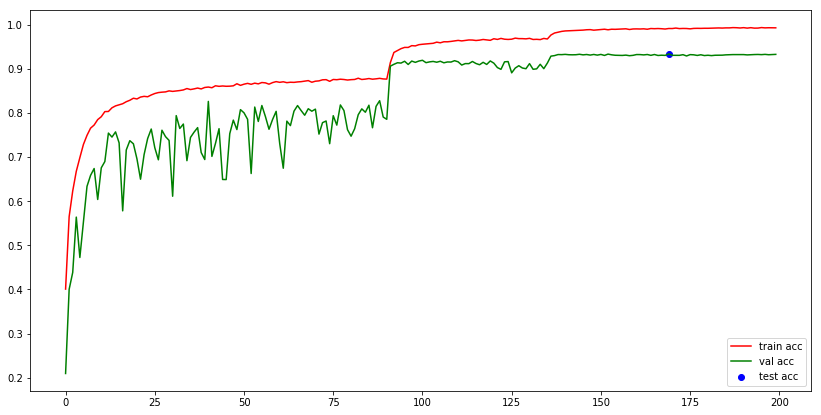

In [21]:
plt.figure(figsize=(14,7))
plt.plot(list(range(EPOCHS)), hist_dict['acc'], color='red', label='train acc')
plt.plot(list(range(EPOCHS)), hist_dict['val_acc'], color='green', label='val acc')
plt.scatter([best_epoch, ], [acc_test, ], color='blue', label='test acc')
plt.legend(loc='lower right')

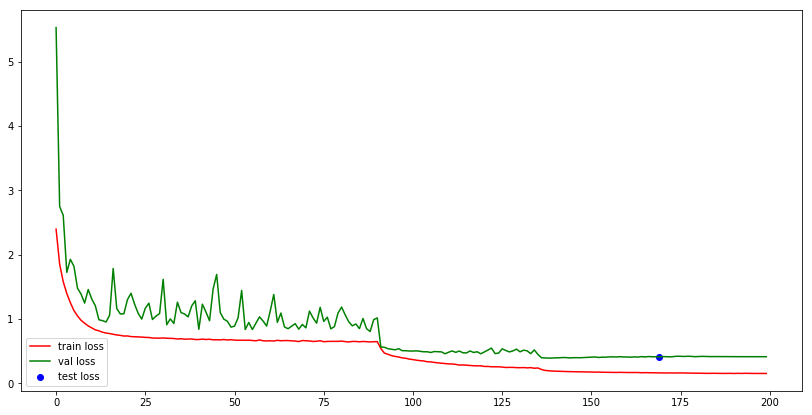

In [22]:
plt.figure(figsize=(14,7))
plt.plot(list(range(EPOCHS)), hist_dict['loss'], color='red', label='train loss')
plt.plot(list(range(EPOCHS)), hist_dict['val_loss'], color='green', label='val loss')
plt.scatter([best_epoch, ], [loss_test, ], color='blue', label='test loss')
plt.legend(loc='lower left')